# Run Once

In [1]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [2]:
# everytime you start a Colab session, you mount Google Drive and copy it from there.
from google.colab import drive
drive.mount('/content/drive/') # mount your drive
%cd '/content/drive/My Drive/Notability/AI6128 Urban Computing/indoor-location-competition-20-master/'


Mounted at /content/drive/
/content/drive/My Drive/Notability/AI6128 Urban Computing/indoor-location-competition-20-master


In [3]:
# install necessary packages
import sys
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

!pip install numpy scipy dataclasses plotly pillow kaleido impyute

import numpy as np
import scipy
import dataclasses
import plotly
import matplotlib.pyplot as plt
import copy
import impyute as impy

# import pillow
# import kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.3 MB/s 


# Compute_f.py

In [4]:
# this cell contains the content from compute_f.py
import numpy as np
import scipy.signal as signal


def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions


def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, posi_datas)

    return step_positions


# io_f.py

In [ ]:
# this cell contain the content from io_f.py
from dataclasses import dataclass

import numpy as np


@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)


#  visualize_f.py

In [ ]:
# this cell contains the content from visualize_f.py
import plotly.graph_objs as go
from PIL import Image


def save_figure_to_html(fig, filename):
    fig.write_html(filename)


def save_figure_as_png(fig, filename):
    fig.savefig(filename)


def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines + markers + text', show=False):
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start Point: 0'
    text_list[-1] = f'End Point: {trajectory.shape[0] - 1}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgb(100, 10, 100)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


def visualize_heatmap(position, value, floor_plan_filename, width_meter, height_meter, colorbar_title="colorbar", title=None, show=False):
    fig = go.Figure()

    # add heat map
    fig.add_trace(
        go.Scatter(x=position[:, 0],
                   y=position[:, 1],
                   mode='markers',
                   marker=dict(size=7,
                               color=value,
                               colorbar=dict(title=colorbar_title),
                               colorscale="Rainbow"),
                   text=value,
                   name=title))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


# Wifi_RSS


In [5]:
import json
import os
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import plotly.graph_objs as go
from PIL import Image

from compute_f import split_ts_seq, compute_step_positions


@dataclass
class ReadData:
    acce: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    waypoint: np.ndarray

def read_data_file(data_filename):
    acce = []
    ahrs = []
    wifi = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            # timestamp | x | y | z
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            # timestamp | x | y | z
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            # timestamp | ssid (wifi name) | bssid (wifi AP address) | RSSI | last seen timestamp 
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            # timestamp | x location | y location

    acce = np.array(acce)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    waypoint = np.array(waypoint)

    return ReadData(acce, ahrs, wifi, waypoint)


def get_wifis_by_position(path_file_list):
    pos_wifi_datas = {}
    # keys : xy positions based on step
    # values : wifi data
    for path_filename in path_file_list:
      # print(f'Processing {path_filename}...')
      path_datas = read_data_file(path_filename)
      acce_datas = path_datas.acce
      ahrs_datas = path_datas.ahrs
      wifi_datas = path_datas.wifi
      posi_datas = path_datas.waypoint
      step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
      # timestamp | x location | y location
      if wifi_datas.size != 0:
        sep_tss = np.unique(wifi_datas[:, 0].astype(float))
        wifi_datas_list = split_ts_seq(wifi_datas, sep_tss)
        for wifi_ds in wifi_datas_list:
          diff = np.abs(step_positions[:, 0] - float(wifi_ds[0, 0]))
          index = np.argmin(diff)
          target_xy_key = tuple(step_positions[index, 1:3])
          if target_xy_key in pos_wifi_datas:
              pos_wifi_datas[target_xy_key] = np.append(pos_wifi_datas[target_xy_key], wifi_ds, axis=0)
          else:
              pos_wifi_datas[target_xy_key] = wifi_ds
    
    return pos_wifi_datas


def extract_wifi_rssi(pos_wifi_datas):
    wifi_rssi = {}
    # external keys : bssid
    # external values / internal keys : x location, y location
    #                   internal value : rssi
    for position_key in pos_wifi_datas:
        wifi_data = pos_wifi_datas[position_key]
        for wifi_d in wifi_data:
            bssid = wifi_d[2]
            rssi = int(wifi_d[3])
            if bssid in wifi_rssi:
                position_rssi = wifi_rssi[bssid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])
            wifi_rssi[bssid] = position_rssi

    return wifi_rssi



def visualize_heatmap(position, value, floor_plan_filename, width_meter, height_meter, title, show=False):
    fig = go.Figure()
    # add heat map
    fig.add_trace(
        go.Scatter(x=position[:, 0],
                   y=position[:, 1],
                   mode='markers',
                   marker=dict(size=7,
                               color=value,
                               colorbar=dict(title="dBm"),
                               colorscale="Rainbow"),
                   text=value,
                   name=title))
    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])
    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


def save_figure_as_png(fig, filename):
    fig.write_image(filename)


if __name__ == "__main__":
  data_dir = { ### for actual code ###
      'site1': ['B1', 'F1', 'F2', 'F3', 'F4'],
      'site2': ['B1', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']      
  }

  # data_dir = { ### for DL model ###
  #     'site1': ['F1']
  # }

  for site_dir, floor_dirs in data_dir.items():
    for floor_dir in floor_dirs:

      # get floor data directory, floor plan image and info, and create output save directory
      floor_data_dir = './data/' + site_dir + '/' + floor_dir
      path_data_dir = floor_data_dir + '/path_data_files'
      floor_plan_filename = floor_data_dir + '/floor_image.png'
      floor_info_filename = floor_data_dir + '/floor_info.json'
      wifi_image_save_dir = './output/' + site_dir + '/' + floor_dir
      Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)

      # get floor info
      with open(floor_info_filename) as f:
          floor_info = json.load(f)
      width_meter = floor_info["map_info"]["width"]
      height_meter = floor_info["map_info"]["height"]

      # get wifi data based on step positions
      path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))
      pos_wifi_datas = get_wifis_by_position(path_filenames)
      step_positions = np.array(list(pos_wifi_datas.keys()))
      wifi_rssi = extract_wifi_rssi(pos_wifi_datas)

      # choose random 3 wifi AP to see RSSI fingerprints
      rng = np.random.default_rng()

      ### choose 3 wifi AP for DL model ###
      target_wifi = ['0a:74:9c:2d:06:cf', 'ec:56:23:f8:dc:74', '1e:74:9c:2b:3a:37']

      for i in range(3):
        ### for actual code ###
        target_wifi_index = rng.integers(low=0, high=len(wifi_rssi.keys()))
        target_wifi = list(wifi_rssi.keys())[target_wifi_index]

        # get all step locations (fingerprints) that sees the chosen wifi AP
        heat_positions = np.array(list(wifi_rssi[target_wifi].keys()))

        # get corresponding RSSI value
        heat_values = np.array(list(wifi_rssi[target_wifi].values()))[:, 0]
        
        # visualize heatmap
        fig = visualize_heatmap(heat_positions, heat_values, floor_plan_filename, width_meter, height_meter, title=f'{site_dir}, {floor_dir}, Wifi AP {i+1}: {target_wifi} RSSI', show=True)
        
        # # save fig as png file
        # png_filename = f'{wifi_image_save_dir}/{target_wifi.replace(":", "-")}.png'
        # png_filename = str(Path(png_filename).resolve())
        # save_figure_as_png(fig, png_filename)
        
        # ### for DL model ###
        # # get all step locations (fingerprints) that sees the chosen wifi AP
        # heat_positions = np.array(list(wifi_rssi[target_wifi[i]].keys())) # for DL model

        # # get corresponding RSSI value
        # heat_values = np.array(list(wifi_rssi[target_wifi[i]].values()))[:, 0] # for DL model

        # # visualize heatmap
        # fig = visualize_heatmap(heat_positions, heat_values, floor_plan_filename, width_meter, height_meter, title=f'{site_dir}, {floor_dir}, Wifi AP {i+1}: {target_wifi[i]} RSSI', show=True)
        


Output hidden; open in https://colab.research.google.com to view.

# Wifi RSS DL fingerprinting model Attempt 1


In [ ]:
import pandas as pd
# get site, floor, and 3 chosen WiFi AP

site_dir = 'site1'
floor_dir = 'F1'
target_wifi = ['0a:74:9c:2d:06:cf', 'ec:56:23:f8:dc:74', '1e:74:9c:2b:3a:37']

# get floor data directory, floor plan image and info, and create output save directory
floor_data_dir = './data/' + site_dir + '/' + floor_dir
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'
wifi_image_save_dir = './output/' + site_dir + '/' + floor_dir
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)

# get floor info
with open(floor_info_filename) as f:
  floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

# get wifi data based on step positions
path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))
pos_wifi_datas = get_wifis_by_position(path_filenames)
step_positions = np.array(list(pos_wifi_datas.keys()))
wifi_rssi = extract_wifi_rssi(pos_wifi_datas)

# store relevant data as pd.Dataframe
pos_wifi_rssi_F1_df = pd.DataFrame.from_dict(wifi_rssi)
# pos_wifi_rssi_F1_df = pos_wifi_rssi_F1_df[target_wifi].dropna(how='all')
pos_wifi_rssi_F1_df

,,16:74:9c:2b:61:6a,0a:74:9c:2b:61:6b,0e:74:9c:2b:61:6b,12:74:9c:2b:61:6b,1e:74:9c:2b:61:6b,06:74:9c:2b:61:6b,16:74:9c:2b:61:6b,06:74:9c:2b:61:6a,0a:74:9c:2b:61:6a,12:74:9c:2b:61:6a,...,0e:74:9c:2b:55:9f,12:74:9c:2b:55:9f,50:fa:84:86:21:91,1a:74:9c:2f:07:2e,0a:74:9c:2f:07:2e,50:fa:84:83:1e:92,70:af:6a:be:aa:66,48:bd:3d:97:b5:70,50:98:b8:89:84:00,c4:ff:1f:5f:3f:3f
218.791824,89.847423,"[-46, 1]","[-53, 1]","[-53, 1]","[-53, 1]","[-53, 1]","[-53, 1]","[-53, 1]","[-60, 1]","[-60, 1]","[-60, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221.580879,89.845745,"[-46, 1]","[-52, 1]","[-52, 1]","[-53, 1]","[-52, 1]","[-51, 1]","[-53, 1]","[-55, 1]","[-57, 1]","[-55, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224.690087,89.148466,"[-65, 1]","[-50, 1]","[-49, 1]","[-49, 1]","[-49, 1]","[-50, 1]","[-53, 1]","[-60, 1]","[-61, 1]","[-60, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228.058281,88.492536,"[-56, 1]","[-51, 1]","[-52, 1]","[-51, 1]","[-51, 1]","[-50, 1]","[-53, 1]","[-50, 1]","[-50, 1]","[-49, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230.425600,87.867709,"[-48, 1]","[-49, 1]","[-49, 1]","[-49, 1]","[-49, 1]","[-50, 1]","[-53, 1]","[-48, 1]","[-48, 1]","[-47, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# import copy

# wifi_rssi = extract_wifi_rssi(pos_wifi_datas)
# wifi_rssi2 = copy.deepcopy(wifi_rssi)

# for i in list(wifi_rssi2.keys()):
#   xy_pos_data = wifi_rssi2[i]
#   for xy_pos in xy_pos_data:
#     wifi_rssi2[i][xy_pos] = wifi_rssi2[i][xy_pos][0]
#     # print('Original: ', wifi_rssi[i][xy_pos], '\t New: ', wifi_rssi2[i][xy_pos])

# pos_wifi_rssi_df2 = pd.DataFrame.from_dict(wifi_rssi2)
# pos_wifi_rssi_df2 = pos_wifi_rssi_df2[target_wifi].dropna(how='all')
# pos_wifi_rssi_df2
# display(pos_wifi_rssi_df2.iloc)
# x_pos = pos_wifi_rssi_df2.index
# list(x_pos)

# pos_wifi_rssi_df3 = pd.DataFrame.from_records(wifi_rssi2, columns=target_wifi)
# pos_wifi_rssi_df3 = pos_wifi_rssi_df3[target_wifi].dropna(how='all')
# pos_wifi_rssi_df3['xy_pos'] = list(pos_wifi_rssi_df2.index)
# pos_wifi_rssi_df3

# print(pos_wifi_rssi_F1_df.shape)
# print(len(wifi_rssi))
# print(list(wifi_rssi.keys())[0])
# print(type(target_wifi))
# print(type(list(wifi_rssi2.keys())))

# ## For Getting specific WiFi AP
# target_wifi = '1e:74:9c:2b:3a:37'
# print('Wifi AP bssid: ', target_wifi)
# heat_positions = np.array(list(wifi_rssi[target_wifi].keys()))
# heat_values = np.array(list(wifi_rssi[target_wifi].values()))[:, 0]
# fig = visualize_heatmap(heat_positions, heat_values, floor_plan_filename, width_meter, height_meter, title=f'{site_dir}, {floor_dir}, Wifi AP 3: {target_wifi} RSSI', show=True)

# png_filename = f'{wifi_image_save_dir}/{target_wifi.replace(":", "-")}.png'
# png_filename = str(Path(png_filename).resolve())
# save_figure_as_png(fig, png_filename)

##

## test model predictions using input data ##
# with torch.no_grad():
#     predicted_xy = model(features)
#     acc = (((predicted_xy - xy_pos_label)**2).sum() / n_samples)**0.5 
#     print(f'Euclidean distance accuracy = {acc:.4f}m')

print(type(input_size))

<class 'int'>


# Wifi RSS DL fingerprinting model (All WIFI AP in Floor)
(Don't run, might take a few hours depending on number of epoch(1h for 1000 epoch))



In [ ]:
###### Linear  Regression ######

# 0) Prepare data
# 1) Design model (input, output size, forward pass)
# 2) Construct loss and optimizer
# 3) training loop
#     forward pass: compute prediction
#     backward pass: gradients
#     update weights

pos_wifi_rssi_dict = {}
# Dictionary keys: xy pos
# Dictionary values: [rssi_wifi1, rssi_wifi2, ... rssi_wifi_last, x_pos, y_pos]
undetected = -100
# undetected = np.nan
n_features = len(wifi_rssi)

for i in range(len(list(wifi_rssi.keys()))):
  wifi_ap = list(wifi_rssi.keys())[i]
  xy_pos_data = wifi_rssi[wifi_ap]
  for xy_pos in xy_pos_data:
    rssi_data = np.zeros(n_features+2)
    rssi_data[:] = undetected
    rssi_data[n_features] = xy_pos[0]
    rssi_data[n_features+1] = xy_pos[1]
    # rssi_wifi1 | rssi_wifi2 ... rssi_wifi[last] | x_pos | y_pos
    if xy_pos in pos_wifi_rssi_dict:
      pos_wifi_rssi_dict[xy_pos][i] = wifi_rssi[wifi_ap][xy_pos][0]
    else:
      rssi_data[i] = wifi_rssi[wifi_ap][xy_pos][0]
      pos_wifi_rssi_dict[xy_pos] = rssi_data

pos_wifi_rssi_array = np.array(list(pos_wifi_rssi_dict.values()))

# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# pos_wifi_rssi_array = imp.fit_transform(pos_wifi_rssi_array)

# Print some samples and examples
print(pos_wifi_rssi_array[0:6,:])
print('No. of rows: ', len(pos_wifi_rssi_array))
print('No. of columns: ', len(pos_wifi_rssi_array[0]))
print('x position example: ', pos_wifi_rssi_array[0][n_features])
print('y position example: ', pos_wifi_rssi_array[0][n_features+1])
print('rssi example: ', pos_wifi_rssi_array[0][0])

# Get feature array and label array
features_np = pos_wifi_rssi_array[:,:n_features]
xy_pos_label_np = pos_wifi_rssi_array[:,n_features:(n_features+2)]

# Convert from numpy to torch
features = torch.from_numpy(features_np.astype(np.float32))
xy_pos_label = torch.from_numpy(xy_pos_label_np.astype(np.float32))

# Reshape labels
xy_pos_label = xy_pos_label.view(xy_pos_label.shape[0], 2)

n_samples = len(pos_wifi_rssi_array)
print('Number of samples: ', n_samples)
print('Number of features: ', n_features)


## 1) model

input_size = n_features
hidden_size = input_size // 2
output_size = 2

# # Simplest model
# model = nn.Linear(input_size, output_size)

# Testing Multilayer model
class DLModel(nn.Module):    
    def __init__(self, n_input_features, hidden_sz, output_sz):
        super(DLModel, self).__init__()
        self.n_input_features = n_input_features
        self.linear1 = nn.Linear(n_input_features, hidden_sz)
        self.relu1 = nn.PReLU()
        self.linear2 = nn.Linear(hidden_sz, output_sz)
        
    def forward(self, x):
        output = self.linear1(x)
        output = self.relu1(output)
        output = self.linear2(output)
        return output

model = DLModel(input_size, hidden_size, output_size)

## 2) loss and optimizer
learning_rate = 0.000001
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

## 3a) training loop
n_iterations = 10000
for epoch in range(n_iterations):
    # forward pass and loss
    xy_predicted = model(features)
    loss = criterion(xy_predicted, xy_pos_label)
    
    # backward pass
    loss.backward()
    losses = np.append(losses, loss.item())
    
    # update
    optimizer.zero_grad()
    optimizer.step()

    if (epoch+1) % 1000 == 0 :
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

## 3b) Plot losses
plt.plot(losses)
plt.xlabel('Epoch count')
plt.ylabel('Loss')

## 4) test model predictions using input data ##
with torch.no_grad():
    predicted_xy = model(features)
    acc = (((predicted_xy - xy_pos_label)**2).sum() / n_samples)**0.5
    print(f'Euclidean distance accuracy = {acc:.4f}m')


[[-46.         -53.         -53.         ... -87.         218.7918241
   89.84742294]
 [-46.         -52.         -52.         ... -87.         221.58087887
   89.84574492]
 [-65.         -50.         -49.         ... -87.         224.69008656
   89.14846635]
 [-56.         -51.         -52.         ... -87.         228.05828147
   88.4925356 ]
 [-48.         -49.         -49.         ... -87.         230.42560032
   87.86770852]
 [-48.         -51.         -51.         ... -87.         231.34203337
   87.13043238]]
No. of rows:  2099
No. of columns:  2526
x position example:  218.7918240992398
y position example:  89.84742294062781
rssi example:  -46.0
Number of samples:  2099
Number of features:  2524
epoch: 100, loss = 1733.0239
epoch: 200, loss = 1720.5137
epoch: 300, loss = 1707.2706
epoch: 400, loss = 1692.4006
epoch: 500, loss = 1675.8486
epoch: 600, loss = 1655.7742
epoch: 700, loss = 1633.1101
epoch: 800, loss = 1606.7539
epoch: 900, loss = 1576.2784
epoch: 1000, loss = 1639.1

# Wifi RSS DL fingerprinting model (3 WIFI AP in Floor)

[[ -82.         -100.         -100.          218.7918241    89.84742294]
 [ -82.         -100.         -100.          221.58087887   89.84574492]
 [ -82.         -100.         -100.          224.69008656   89.14846635]
 [ -82.         -100.         -100.          228.05828147   88.4925356 ]
 [ -82.         -100.         -100.          230.42560032   87.86770852]
 [ -82.         -100.         -100.          231.34203337   87.13043238]
 [ -87.         -100.         -100.          231.03133      85.43779   ]
 [ -90.          -81.         -100.          176.69051764   54.73161344]
 [ -90.          -81.         -100.          178.9061476    54.21292558]
 [ -88.          -81.         -100.          180.35363155   53.98913304]
 [ -80.         -100.         -100.          183.61748683   53.30188164]
 [ -83.          -76.         -100.          187.27753361   51.9257584 ]
 [ -86.          -76.         -100.          189.46620024   51.05771917]
 [ -85.          -78.         -100.          189.76


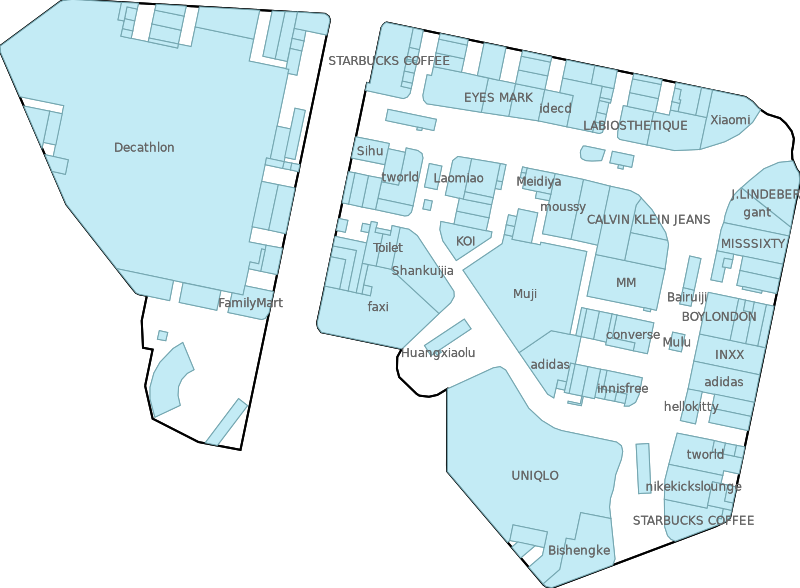


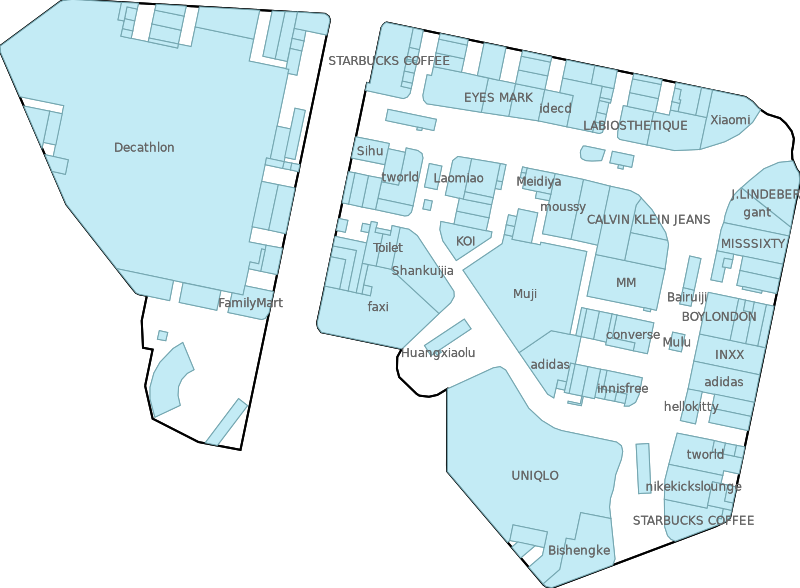


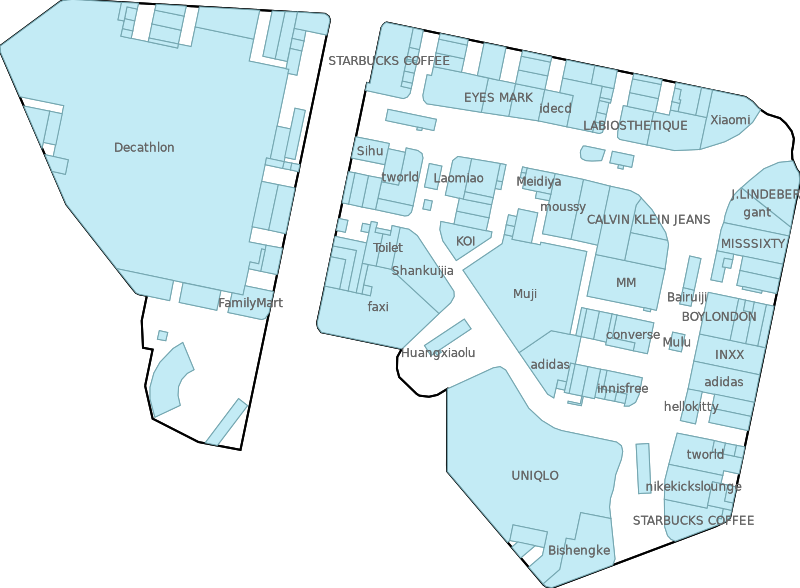

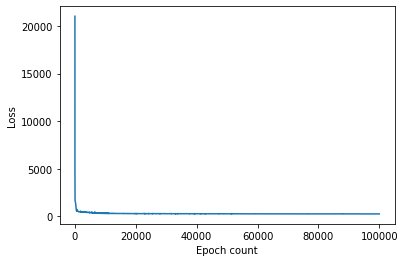

In [10]:
###### Linear  Regression ######

# -1) Get data
# 0) Prepare data
# 1) Design model (input, output size, forward pass)
# 2) Construct loss and optimizer
# 3) training loop
#     forward pass: compute prediction
#     backward pass: gradients
#     update weights

import numpy as np
import torch
import torch.nn as nn
import impyute as impy
import matplotlib.pyplot as plt
import Wifi_RSSI

## -1) Get data

# Choose site, and floor for model 
site_dir = 'site1'
floor_dir = 'F1'
target_wifi = ['0a:74:9c:2d:06:cf', 'ec:56:23:f8:dc:74', '1e:74:9c:2b:3a:37']

# Get floor data directory, floor plan image and info, and create output save directory
floor_data_dir = './data/' + site_dir + '/' + floor_dir
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'
wifi_image_save_dir = './output/' + site_dir + '/' + floor_dir
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)

# Get floor info
with open(floor_info_filename) as f:
  floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

# Get wifi data based on step positions
path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))
pos_wifi_datas = get_wifis_by_position(path_filenames)
step_positions = np.array(list(pos_wifi_datas.keys()))
wifi_rssi = extract_wifi_rssi(pos_wifi_datas)


## 0) prepare data

pos_wifi_rssi_dict = {}
# Dictionary keys: xy pos
# Dictionary values: [rssi_wifi1, rssi_wifi2, rssi_wifi3, x_pos | y_pos]
undetected = -100
# undetected = np.nan
n_features = len(wifi_rssi)

for i in range(len(target_wifi)):
  xy_pos_data = wifi_rssi[target_wifi[i]]
  for xy_pos in xy_pos_data:
    rssi_data = [undetected, undetected, undetected, xy_pos[0], xy_pos[1]]
    # rssi_wifi1 | rssi_wifi2 | rssi_wifi3 | x_pos | y_pos
    if xy_pos in pos_wifi_rssi_dict:
      pos_wifi_rssi_dict[xy_pos][i] = wifi_rssi[target_wifi[i]][xy_pos][0]
    else:
      rssi_data[i] = wifi_rssi[target_wifi[i]][xy_pos][0]
      pos_wifi_rssi_dict[xy_pos] = rssi_data

pos_wifi_rssi_array = np.array(list(pos_wifi_rssi_dict.values()))

# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# pos_wifi_rssi_array = imp.fit_transform(pos_wifi_rssi_array)

# Print some samples and examples
print(pos_wifi_rssi_array[0:15,:])
print('x position example: ', pos_wifi_rssi_array[0][3])
print('y position example: ', pos_wifi_rssi_array[0][4])
print('rssi example: ', pos_wifi_rssi_array[0][0])

# Get feature array and label array
features_np = pos_wifi_rssi_array[:,:3]
xy_pos_label_np = pos_wifi_rssi_array[:,3:5]

# Convert from numpy to torch
features = torch.from_numpy(features_np.astype(np.float32))
xy_pos_label = torch.from_numpy(xy_pos_label_np.astype(np.float32))

# Reshape labels
xy_pos_label = xy_pos_label.view(xy_pos_label.shape[0], 2)

n_samples = len(pos_wifi_rssi_array)
n_features = len(target_wifi)
print('Number of samples: ', n_samples)
print('Number of features: ', n_features)

## 1) model

# # Simplest model
# input_size = n_features
# output_size = 2
# model = nn.Linear(input_size, output_size)

# Testing Multilayer model
input_size = n_features
hidden_size1 = n_features * 8
hidden_size2 = hidden_size1 // 2
hidden_size3 = hidden_size2 // 2
output_size = 2

class DLModel(nn.Module):    
    def __init__(self, n_input_features, hidden_sz1, hidden_sz2, hidden_sz3, output_sz):
        super(DLModel, self).__init__()
        self.n_input_features = n_input_features
        self.linear1 = nn.Linear(n_input_features, hidden_sz1)
        self.relu1 = nn.PReLU()
        self.linear2 = nn.Linear(hidden_sz1, hidden_sz2)
        self.relu2 = nn.PReLU()
        self.linear3 = nn.Linear(hidden_sz2, hidden_sz3)
        self.relu3 = nn.PReLU()
        self.linear4 = nn.Linear(hidden_sz3, output_sz)
        
    def forward(self, x):
        output = self.linear1(x)
        output = self.relu1(output)
        output = self.linear2(output)
        output = self.relu2(output)
        output = self.linear3(output)
        output = self.relu3(output)
        output = self.linear4(output)
        return output

model = DLModel(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

## 2) loss and optimizer
learning_rate = 0.000008
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []

## 3a) training loop
n_iterations = 100000
for epoch in range(n_iterations):
    # forward pass and loss
    xy_predicted = model(features)
    loss = criterion(xy_predicted, xy_pos_label)

    # backward pass
    loss.backward()
    losses = np.append(losses, loss.item())
    
    # update
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch+1) % 10000 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

## 3b) Plot losses
plt.plot(losses)
plt.xlabel('Epoch count')
plt.ylabel('Loss')

## 4) Test model prediction accuracy using input data ##
with torch.no_grad():
    predicted_xy = model(features)
    acc = (((predicted_xy - xy_pos_label)**2).sum() / n_samples)**0.5 
    print(f'Euclidean distance accuracy = {acc:.4f}m')

## 5) Get model predictions using random rssi values ##
# First sample of random rssi reading should have result similar to first few samples of training data
random_rssi_reading = np.array([[-82, undetected, undetected], [-85, -77, undetected]])
rssi_reading = torch.from_numpy(random_rssi_reading.astype(np.float32))

with torch.no_grad():
    predicted_xy = model(rssi_reading).detach().numpy()
    heat_position = predicted_xy
    for i in range(len(predicted_xy)):
        print(f'Predicted coordinates of random RSSI reading {random_rssi_reading[i]} = {heat_position[i]}')

    for i in range(n_features):
        heat_value = random_rssi_reading[:,i]
        fig = visualize_heatmap(heat_position, heat_value, floor_plan_filename, width_meter, height_meter, title=f'{site_dir}, {floor_dir}, Wifi AP {i+1}: {target_wifi[i]} RSSI', show=True)


# Sherbelle's geomagnetic heatmap

In [ ]:
import base64
import json
import os
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from compute_f import compute_step_positions


def read_data_file(data_filename: str, verbose: bool = False
                   ) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to read txt file provided and extract 4 key pieces of information.

    Args:
        data_filename: path to file holding raw data
        verbose: flag on whether to print helper messages

    Returns:
        A tuple (acce_data, magn_data, ahrs_data, wayp_data) where:
        - acce_data: ` timestamp | x | y | z ` data of `TYPE_ACCELEROMETER`
        - magn_data: ` timestamp | x | y | z ` data of `TYPE_MAGNETIC_FIELD`
        - ahrs_data: ` timestamp | x | y | z ` data of `TYPE_ROTATION_VECTOR`
        - wayp_data: ` timestamp | x | y ` data of `TYPE_WAYPOINT`
    """
    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    acce_data = []
    magn_data = []
    ahrs_data = []
    wayp_data = []

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            # timestamp | x | y | z
            acce_data.append(
                [int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            # timestamp | x | y | z
            magn_data.append(
                [int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            # timestamp | x | y | z
            ahrs_data.append(
                [int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            # timestamp | x | y
            wayp_data.append(
                [int(line_data[0]), float(line_data[2]), float(line_data[3])])
        
    if verbose:
        print(f"# of accelerometer data: {len(acce_data)}")
        print(f"# of geomagnetic data  : {len(magn_data)}")
        print(f"# of rotation vect data: {len(ahrs_data)}")
        print(f"# of waypoints data    : {len(wayp_data)}")

    acce_data = np.array(acce_data)
    magn_data = np.array(magn_data)
    ahrs_data = np.array(ahrs_data)
    wayp_data = np.array(wayp_data)
    
    return acce_data, magn_data, ahrs_data, wayp_data


def get_nearest_position_to_magn_data(step_pos: np.array, magn_data: np.array) -> pd.DataFrame:
    """Maps magnetic strength data to its nearest position based on timestamp values.

    Args:
        step_pos: maps timestamp to x,y coordinates
        magn_data: maps timestamp to x,y,z magnetic values

    Returns:
        A pandas dataframe holding mapping of step position coordinates to magnetic strength values
    """
    # Convert to pandas dataframe
    magn_data_df = pd.DataFrame(data=magn_data, columns=['timestamp', 'x', 'y', 'z'])
    step_pos_df = pd.DataFrame(data=step_pos, columns=['timestamp', 'x', 'y'])

    # Ensure no duplicated timestamp
    magn_data_df = magn_data_df.sort_values(by=['timestamp']).drop_duplicates(keep='first')

    # Get join both dataframes based on nearest timestamp
    mag_pos_datas = pd.merge_asof(
        magn_data_df, step_pos_df, on="timestamp", direction='nearest', suffixes=('', '_pos'))

    return mag_pos_datas


def calculate_magnetic_strength(mag_pos_datas: pd.DataFrame) -> pd.DataFrame:
    """Calculates average magnetic strength at each position.

    Args:
        mag_pos_datas: holds magnetic strength readings for each positions.

    Returns:
        A pandas dataframe holding the average magnetic strength reading for each position
    """
    mag_pos_datas['magn_strength'] = (
        mag_pos_datas['x'] ** 2 + mag_pos_datas['y'] ** 2 + mag_pos_datas['z']**2)
    mag_pos_datas['magn_strength'] = np.sqrt(mag_pos_datas['magn_strength'])
    
    avg_magn_strength = mag_pos_datas.groupby(['x_pos', 'y_pos'], as_index=False)['magn_strength'].mean()
    return avg_magn_strength


def plot_and_save_geomagnetic_heatmap(mag_strength_pos_data: pd.DataFrame, path_dir: str, site_id: int,
                                      floor_id: str, save_img: bool = False):
    """Plot the average geomagnetic stregnth as a heatmap, overlaid on the site floorplan.

    Args:
        mag_strength_pos_data: holds the average magnetic strength reading for each position
        path_dir: directory to read floorplan and metadata from
        site_id: ID of site
        floor_id: floor level
        save_img: flag on whether to save the heatmap as a png file
    """
    # Get data for plotting
    x_pos = mag_strength_pos_data['x_pos'].values
    y_pos = mag_strength_pos_data['y_pos'].values
    strength = mag_strength_pos_data['magn_strength'].values

    data = []
    # Plot heatmap
    data.append(go.Scatter(
        x=x_pos, y=y_pos,
        mode='markers',
        marker=dict(
            color=strength,
            colorbar=dict(title="Geomagnetic Strength"),
            colorscale="Rainbow"
        )
    ))
    
    # Add floor plan
    with open(os.path.join(path_dir, 'floor_info.json')) as f:
        floor_info = json.load(f)
    height_meter = floor_info['map_info']['height']
    width_meter = floor_info['map_info']['width']
    with open(os.path.join(path_dir, 'floor_image.png'), 'rb') as image_file:
        floor_plan = base64.b64encode(image_file.read()).decode('utf-8')
    img_bg = {
        'source': f'data:image/png;base64,{floor_plan}',
        'xref': 'x', 'yref': 'y',
        'x': 0, 'y': height_meter,
        'sizex': width_meter, 'sizey': height_meter,
        'sizing': 'contain', 'opacity': 1, 'layer': "below",
    }
    
    layout = go.Layout(
        xaxis=dict(autorange=False, range=[0, width_meter], showticklabels=False, showgrid=False, zeroline=False),
        yaxis=dict(autorange=False, range=[0, height_meter], showticklabels=False, showgrid=False, zeroline=False,
                   scaleanchor='x', scaleratio=1),
        title=go.layout.Title(
            text=f'Geomagnetic Heat Map for Site {site_id} - {floor_id}',
            xref='paper',
            x=0,
        ),
        autosize=True,
        width=900,
        height=100 + 900 * height_meter / width_meter,
        template='plotly_white',
        images=[img_bg]
    )
    
    fig = go.Figure(data=data, layout=layout)
    fig.show()
    
    if save_img:
        output_filepath = f"./outputs/site{site_id}"
        Path(output_filepath).mkdir(parents=True, exist_ok=True)
        fig.write_image(os.path.join(output_filepath, f'{floor_id}.png'))


def get_geomagnetic_heatmap(site_id: int, floor_id: str, save_img: bool = False):
    """Function to get a heatmap of the average geomagnetic strength of a given floor in a given site.

    Args:
        site_id: ID of site
        floor_id: floor level
        save_img: flag on whether to save the heatmap as a png file
    """
    path_dir = f'./indoor-location-competition-20/data/site{site_id}/{floor_id}'
    data_files_path_dir = os.path.join(path_dir, 'path_data_files')
    data_filenames = [f for f in os.listdir(data_files_path_dir)
                      if os.path.isfile(os.path.join(data_files_path_dir, f))]
    
    mag_pos_datas = []
    for data_filename in data_filenames:
        data_filename = os.path.join(data_files_path_dir, data_filename)
        acce_data, magn_data, ahrs_data, wayp_data = read_data_file(data_filename)
        step_pos = compute_step_positions(acce_data, ahrs_data, wayp_data)
        mag_pos_datas.append(get_nearest_position_to_magn_data(step_pos, magn_data))
    
    mag_pos_data_df = pd.concat(mag_pos_datas, ignore_index=True)

    mag_strength_pos_data = calculate_magnetic_strength(mag_pos_data_df)
    
    plot_and_save_geomagnetic_heatmap(mag_strength_pos_data, path_dir, site_id, floor_id, save_img)


if __name__ == "__main__":
    places_to_map = {
        1: ['B1', 'F1', 'F2', 'F3', 'F4'],
        2: ['B1', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'],
    }
    
    for site_id, floor_ids in places_to_map.items():
        for floor_id in floor_ids:
            get_geomagnetic_heatmap(site_id, floor_id, save_img=True)